## Load the data

In [1]:
using DataDrop

In [2]:
P_max = DataDrop.retrieve_matrix("PTDF_data/P_max_gen.h5");

In [3]:
P_exp = DataDrop.retrieve_matrix("PTDF_data/P_exp_gen.h5");

In [4]:
P_total = DataDrop.retrieve_matrix("PTDF_data/P_total.h5");

In [5]:
A_ramp = DataDrop.retrieve_matrix("PTDF_data/A_gen_ramp.h5");

In [6]:
ΔP_ramp = DataDrop.retrieve_matrix("PTDF_data/gen_ramp.h5");

In [7]:
linear_line_cost = DataDrop.retrieve_matrix("PTDF_data/linear_line_cost.h5");

In [8]:
linear_gen_cost = DataDrop.retrieve_matrix("PTDF_data/linear_gen_cost.h5");

In [9]:
quadratic_cost = DataDrop.retrieve_matrix("PTDF_data/quadratic_cost.h5");

## Computation

In [10]:
using MiniLoggers

logger = MiniLogger(format="[{timestamp:blue}] {group:red:bold} {message}")
global_logger(logger);

In [11]:
import MathOptInterface as MOI

In [12]:
using Gurobi

const gurobi_env = Gurobi.Env();

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-17


In [13]:
optimizer = MOI.instantiate(MOI.OptimizerWithAttributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

# optimizer = Gurobi.Optimizer(gurobi_env)

    sense  : minimize
    number of variables             = 0
    number of linear constraints    = 0
    number of quadratic constraints = 0
    number of sos constraints       = 0
    number of non-zero coeffs       = 0
    number of non-zero qp objective terms  = 0
    number of non-zero qp constraint terms = 0


In [14]:
function opf(quadratic_cost::AbstractArray{<:Real,2}, linear_cost::AbstractArray{<:Real,2}, 
        P_max::AbstractVector{<:Real}, P_exp::AbstractVector{<:Real}, P_total::AbstractVector{<:Real},
        A_ramp::AbstractArray{<:Real,2} = Array{Real}(undef, 0, 0), ΔP_ramp::AbstractVector{<:Real} = Real[],
        P_ramp_first::AbstractVector{<:Real} = Real[], P_ramp_last::AbstractVector{<:Real} = Real[];
        log_group::String = "")
    
    N = length(P_max)
    T = length(P_total)
    n_ramp = length(ΔP_ramp)

    # check dimensions of the input
    @assert length(P_exp) == N
    @assert size(quadratic_cost) == (N, N)
    @assert size(linear_cost) == (N, T)
    @assert (size(A_ramp) == (n_ramp, N)) || (n_ramp == 0)
    @assert length(P_ramp_first) ∈ [0, n_ramp]
    @assert length(P_ramp_last) == length(P_ramp_first)

    ramp_constraint_type = length(P_ramp_first) == 0 ? "cyclic" : "fixed boundaries"
    @info ("OPF with $T time steps, $N generators, " *
        "and $n_ramp ramp constraints ($ramp_constraint_type)") _group = log_group
    log_group = " "^length(log_group)
    
    # check feasibility of the model
    @info " -> checking model" _group = log_group
    @assert all(P_exp .<= P_max)
    @assert all(ΔP_ramp .>= 0)
    @assert all(P_total .<= sum(P_max))
    @assert abs(sum(P_total) / sum(P_exp) / T - 1) < 1e-3

    # variables
    @info " -> defining variables" _group = log_group
    P_vec = MOI.add_variables(optimizer, N * T)
    P = reshape(P_vec, (N, T))

    # constraints 
    @info " -> defining constraints" _group = log_group
    MOI.add_constraints(optimizer, P_vec, [MOI.Interval(0.0, P_max[i]) for t = 1:T for i = 1:N])

    MOI.add_constraints(optimizer,
        [MOI.ScalarAffineFunction([MOI.ScalarAffineTerm(1.0, P[i,t]) for t = 1:T], 0.0) for i = 2:N],
        [MOI.EqualTo(T * P_exp[i]) for i = 2:N])
    
    MOI.add_constraints(optimizer,
        [MOI.ScalarAffineFunction([MOI.ScalarAffineTerm(1.0, P[i,t]) for i = 1:N], 0.0) for t = 1:T],
        [MOI.EqualTo(P_total[t]) for t = 1:T])
    
    if n_ramp > 0
        P_ramp = A_ramp * P
        if length(P_ramp_first) == 0
            ΔP = [P_ramp[n, t] - P_ramp[n, t % T + 1] for t = 1:T for n = 1:n_ramp]
            MOI.add_constraints(optimizer, ΔP, [MOI.GreaterThan(-ΔP_ramp[n]) for t = 1:T for n = 1:n_ramp])
            MOI.add_constraints(optimizer, ΔP, [MOI.LessThan(ΔP_ramp[n]) for t = 1:T for n = 1:n_ramp])
        else
            ΔP = [P_ramp[n, t] - P_ramp[n, t + 1] for t = 1:T-1 for n = 1:n_ramp]
            MOI.add_constraints(optimizer, ΔP, [MOI.GreaterThan(-ΔP_ramp[n]) for t = 1:T-1 for n = 1:n_ramp])
            MOI.add_constraints(optimizer, ΔP, [MOI.LessThan(ΔP_ramp[n]) for t = 1:T-1 for n = 1:n_ramp])
            P_first = [P_ramp[n, 1] for n = 1:n_ramp]
            MOI.add_constraints(optimizer, P_first, [MOI.GreaterThan(P_ramp_first[n] - ΔP_ramp[n]) for n = 1:n_ramp])
            MOI.add_constraints(optimizer, P_first, [MOI.LessThan(P_ramp_first[n] + ΔP_ramp[n]) for n = 1:n_ramp])
            P_last = [P_ramp[n, T] for n = 1:n_ramp]
            MOI.add_constraints(optimizer, P_last, [MOI.GreaterThan(P_ramp_last[n] - ΔP_ramp[n]) for n = 1:n_ramp])
            MOI.add_constraints(optimizer, P_last, [MOI.LessThan(P_ramp_last[n] + ΔP_ramp[n]) for n = 1:n_ramp])
        end
    end
    
    @info " -> computing objective function" _group = log_group
    quadratic_terms = vcat(
        [MOI.ScalarQuadraticTerm(2.0 * quadratic_cost[i,i], P[i, t], P[i, t]) for i = 1:N for t = 1:T],
        [MOI.ScalarQuadraticTerm(quadratic_cost[i,j], P[i, t], P[j, t]) for i = 1:N for j = (i+1):N for t = 1:T]
    )
    affine_terms = [MOI.ScalarAffineTerm(linear_cost[i, t], P[i, t]) for i = 1:N for t = 1:T]
    objective = MOI.ScalarQuadraticFunction(quadratic_terms, affine_terms, 0.0)
    
    MOI.set(optimizer, MOI.ObjectiveFunction{MOI.ScalarQuadraticFunction{Float64}}(), objective)
    MOI.set(optimizer, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    
    @info " -> optimizing" _group = log_group
    MOI.optimize!(optimizer)
    
    @info " -> exporting results" _group = log_group
    P_vec_solution = MOI.get(optimizer, MOI.VariablePrimal(), P_vec)
    P_vec_solution = map(x -> isapprox(x, 0, atol=1e-6) ? 0.0 : x, P_vec_solution)
    P_solution = reshape(P_vec_solution, (N, T))
    
    return P_solution
end

opf (generic function with 5 methods)

In [15]:
function partitioned_opf(partitions::Vector{Int},
        quadratic_cost::AbstractArray{<:Real,2}, linear_cost::AbstractArray{<:Real,2}, 
        P_max::AbstractVector{<:Real}, P_exp::AbstractVector{<:Real}, P_total::AbstractVector{<:Real},
        A_ramp::AbstractArray{<:Real,2} = Array{Real}(undef, 0, 0), ΔP_ramp::AbstractVector{<:Real} = Real[],
        P_ramp_first::AbstractVector{<:Real} = Real[], P_ramp_last::AbstractVector{<:Real} = Real[];
        log_group::String = "")

    if length(partitions) <= 1
        return opf(quadratic_cost, linear_cost, P_max, P_exp, P_total,
            A_ramp, ΔP_ramp, P_ramp_first, P_ramp_last, log_group = log_group)
    end
    
    N = length(P_max)
    T = length(P_total)
    n_ramp = length(ΔP_ramp)

    # check dimensions of the input that needs to be partitioned
    @assert length(P_exp) == N
    @assert size(quadratic_cost) == (N, N)
    @assert size(linear_cost) == (N, T)
    @assert (size(A_ramp) == (n_ramp, N)) || (n_ramp == 0)
    
    # check that the number of partitions matches the total number of steps
    @assert prod(partitions) == T
    
    n_partitions = partitions[1]
    partition_length = T ÷ n_partitions
    
    counter_width = length(string(n_partitions))    
    @info "Partitioning a dataset of $T time steps into $n_partitions chunks of $partition_length time steps" _group = log_group

    partitioned_P_total = reshape(P_total, (partition_length, n_partitions))
    aggregated_P_total = dropdims(sum(partitioned_P_total, dims=1), dims=1) / partition_length

    partitioned_linear_cost = reshape(linear_cost, (N, partition_length, n_partitions))
    aggregated_linear_cost = dropdims(sum(partitioned_linear_cost, dims=2), dims=2) / partition_length

    aggregated_P_max = (P_max + P_exp) / 2.0
    
    partitioned_P_exp = opf(quadratic_cost, aggregated_linear_cost, aggregated_P_max, P_exp, aggregated_P_total,
        A_ramp, ΔP_ramp, P_ramp_first, P_ramp_last,
        log_group = log_group * " $(lpad(0, counter_width))/$(n_partitions)")

    partitioned_P_ramp = n_ramp > 0 ? A_ramp * partitioned_P_exp : Real[]

    result = Matrix{Float64}(undef, N, 0)
    timing = []
    for a=1:n_partitions

        if length(timing) > 0
            estimated_remaining_time = "Estimated remaining time:"
            s = round(Int, (n_partitions - a + 1) * sum(timing) / length(timing))
            if s >= 60
                m = s ÷ 60
                s = s % 60
                if m >= 60
                    h = m ÷ 60
                    m = m % 60
                    estimated_remaining_time = estimated_remaining_time * " $h h"
                end
                estimated_remaining_time = estimated_remaining_time * " $m min"
            end
            estimated_remaining_time = estimated_remaining_time * " $s s"
            @info estimated_remaining_time _group = log_group
        end
        
        if n_ramp == 0
            partitioned_P_ramp_previous = Real[]
            partitioned_P_ramp_next = Real[]
        else
            if a == 1
                partitioned_P_ramp_previous = length(P_ramp_first) > 0 ? P_ramp_first : partitioned_P_ramp[:, end]
            else
                partitioned_P_ramp_previous = partitioned_P_ramp[:, a - 1]
            end
            if a == n_partitions
                partitioned_P_ramp_next = length(P_ramp_last) > 0 ? P_ramp_last : partitioned_P_ramp[:, 1]
            else
                partitioned_P_ramp_next = partitioned_P_ramp[:, a + 1]
            end
        end
        
        partition_result = @timed partitioned_opf(partitions[2:end], quadratic_cost, partitioned_linear_cost[:,:,a],
            P_max, partitioned_P_exp[:,a], partitioned_P_total[:,a],
            A_ramp, ΔP_ramp, partitioned_P_ramp_previous, partitioned_P_ramp_next,
            log_group = log_group * " $(lpad(a, counter_width))/$(n_partitions)")
        push!(timing, partition_result.time)
        result = hcat(result, partition_result.value)
    end

    return result
end

partitioned_opf (generic function with 5 methods)

## Example

Possible partitions:

In [16]:
52 * 168, 26 * 336, 13 * 672, 12 * 728, 8 * 1092, 4 * 2184

(8736, 8736, 8736, 8736, 8736, 8736)

In [17]:
P_total_reduced = dropdims(sum(reshape(P_total, (728, 12)), dims=1), dims=1) ./ 728
linear_line_cost_reduced = dropdims(sum(reshape(linear_line_cost, (1039, 728, 12)), dims=2), dims=2) ./ 728
linear_gen_cost_reduced = dropdims(sum(reshape(linear_gen_cost, (1039, 728, 12)), dims=2), dims=2) ./ 728;

In [18]:
P_full = opf(quadratic_cost, linear_line_cost_reduced + linear_gen_cost_reduced, P_max, P_exp, P_total_reduced, A_ramp, ΔP_ramp);

[2024-05-29 10:29:14]  OPF with 12 time steps, 1039 generators, and 167 ramp constraints (cyclic)
[2024-05-29 10:29:14]   -> checking model
[2024-05-29 10:29:14]   -> defining variables
[2024-05-29 10:29:14]   -> defining constraints
[2024-05-29 10:29:14]   -> computing objective function
[2024-05-29 10:29:16]   -> optimizing
[2024-05-29 10:31:11]   -> exporting results


In [19]:
P_partitioned = partitioned_opf([3, 4], quadratic_cost, linear_line_cost_reduced + linear_gen_cost_reduced,
    P_max, P_exp, P_total_reduced, A_ramp, ΔP_ramp);

[2024-05-29 10:31:11]  Partitioning a dataset of 12 time steps into 3 chunks of 4 time steps
[2024-05-29 10:31:11]  0/3 OPF with 3 time steps, 1039 generators, and 167 ramp constraints (cyclic)
[2024-05-29 10:31:11]       -> checking model
[2024-05-29 10:31:11]       -> defining variables
[2024-05-29 10:31:11]       -> defining constraints
[2024-05-29 10:31:11]       -> computing objective function
[2024-05-29 10:31:12]       -> optimizing
[2024-05-29 10:31:18]       -> exporting results
[2024-05-29 10:31:19]  1/3 OPF with 4 time steps, 1039 generators, and 167 ramp constraints (fixed boundaries)
[2024-05-29 10:31:19]       -> checking model
[2024-05-29 10:31:19]       -> defining variables
[2024-05-29 10:31:19]       -> defining constraints
[2024-05-29 10:31:19]       -> computing objective function
[2024-05-29 10:31:19]       -> optimizing
[2024-05-29 10:31:29]       -> exporting results
[2024-05-29 10:31:29]  Estimated remaining time: 21 s
[2024-05-29 10:31:29]  2/3 OPF with 4 time 

In [20]:
P_doubly_partitioned = partitioned_opf([2, 2, 3], quadratic_cost, linear_line_cost_reduced + linear_gen_cost_reduced,
    P_max, P_exp, P_total_reduced, A_ramp, ΔP_ramp);

[2024-05-29 10:32:39]  Partitioning a dataset of 12 time steps into 2 chunks of 6 time steps
[2024-05-29 10:32:39]  0/2 OPF with 2 time steps, 1039 generators, and 167 ramp constraints (cyclic)
[2024-05-29 10:32:39]       -> checking model
[2024-05-29 10:32:39]       -> defining variables
[2024-05-29 10:32:39]       -> defining constraints
[2024-05-29 10:32:39]       -> computing objective function
[2024-05-29 10:32:40]       -> optimizing
[2024-05-29 10:32:42]       -> exporting results
[2024-05-29 10:32:42]  1/2 Partitioning a dataset of 6 time steps into 2 chunks of 3 time steps
[2024-05-29 10:32:42]  1/2 0/2 OPF with 2 time steps, 1039 generators, and 167 ramp constraints (fixed boundaries)
[2024-05-29 10:32:42]           -> checking model
[2024-05-29 10:32:42]           -> defining variables
[2024-05-29 10:32:42]           -> defining constraints
[2024-05-29 10:32:42]           -> computing objective function
[2024-05-29 10:32:43]           -> optimizing
[2024-05-29 10:32:46]     

## Comparison between partitions

In [21]:
using Plots

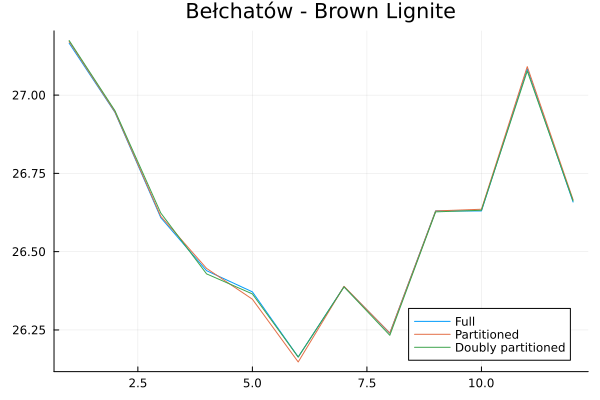

In [22]:
plot(P_full[312, :], label="Full", title="Bełchatów - Brown Lignite")
plot!(P_partitioned[312, :], label="Partitioned")
plot!(P_doubly_partitioned[312, :], label="Doubly partitioned")

## Turning off the noise

In [23]:
P_full_no_noise = opf(quadratic_cost, linear_line_cost_reduced, P_max, P_exp, P_total_reduced, A_ramp, ΔP_ramp);

[2024-05-29 10:33:10]  OPF with 12 time steps, 1039 generators, and 167 ramp constraints (cyclic)
[2024-05-29 10:33:10]   -> checking model
[2024-05-29 10:33:10]   -> defining variables
[2024-05-29 10:33:10]   -> defining constraints
[2024-05-29 10:33:10]   -> computing objective function
[2024-05-29 10:33:11]   -> optimizing
[2024-05-29 10:33:58]   -> exporting results


In [24]:
P_partitioned_no_noise = partitioned_opf([3, 4], quadratic_cost, linear_line_cost_reduced,
    P_max, P_exp, P_total_reduced, A_ramp, ΔP_ramp);

[2024-05-29 10:33:59]  Partitioning a dataset of 12 time steps into 3 chunks of 4 time steps
[2024-05-29 10:33:59]  0/3 OPF with 3 time steps, 1039 generators, and 167 ramp constraints (cyclic)
[2024-05-29 10:33:59]       -> checking model
[2024-05-29 10:33:59]       -> defining variables
[2024-05-29 10:33:59]       -> defining constraints
[2024-05-29 10:33:59]       -> computing objective function
[2024-05-29 10:33:59]       -> optimizing
[2024-05-29 10:34:04]       -> exporting results
[2024-05-29 10:34:04]  1/3 OPF with 4 time steps, 1039 generators, and 167 ramp constraints (fixed boundaries)
[2024-05-29 10:34:04]       -> checking model
[2024-05-29 10:34:04]       -> defining variables
[2024-05-29 10:34:04]       -> defining constraints
[2024-05-29 10:34:04]       -> computing objective function
[2024-05-29 10:34:04]       -> optimizing
[2024-05-29 10:34:11]       -> exporting results
[2024-05-29 10:34:11]  Estimated remaining time: 15 s
[2024-05-29 10:34:11]  2/3 OPF with 4 time 

In [25]:
P_doubly_partitioned_no_noise = partitioned_opf([2, 2, 3], quadratic_cost, linear_line_cost_reduced,
    P_max, P_exp, P_total_reduced, A_ramp, ΔP_ramp);

[2024-05-29 10:34:24]  Partitioning a dataset of 12 time steps into 2 chunks of 6 time steps
[2024-05-29 10:34:24]  0/2 OPF with 2 time steps, 1039 generators, and 167 ramp constraints (cyclic)
[2024-05-29 10:34:24]       -> checking model
[2024-05-29 10:34:24]       -> defining variables
[2024-05-29 10:34:24]       -> defining constraints
[2024-05-29 10:34:24]       -> computing objective function
[2024-05-29 10:34:24]       -> optimizing
[2024-05-29 10:34:27]       -> exporting results
[2024-05-29 10:34:27]  1/2 Partitioning a dataset of 6 time steps into 2 chunks of 3 time steps
[2024-05-29 10:34:27]  1/2 0/2 OPF with 2 time steps, 1039 generators, and 167 ramp constraints (fixed boundaries)
[2024-05-29 10:34:27]           -> checking model
[2024-05-29 10:34:27]           -> defining variables
[2024-05-29 10:34:27]           -> defining constraints
[2024-05-29 10:34:27]           -> computing objective function
[2024-05-29 10:34:27]           -> optimizing
[2024-05-29 10:34:31]     

LoadError: Result index of attribute MathOptInterface.VariablePrimal(1) out of bounds. There are currently 0 solution(s) in the model.

In [26]:
plot(P_full_no_noise[312, :], label="Full", title="Bełchatów - Brown Lignite")
plot!(P_partitioned_no_noise[312, :], label="Partitioned")
plot!(P_doubly_partitioned_no_noise[312, :], label="Doubly partitioned")

LoadError: UndefVarError: `P_doubly_partitioned_no_noise` not defined

## Checks

Check that the total production for all generators is the same in all cases:

In [27]:
[maximum(abs.(sum(P, dims=2) - sum(P_full, dims=2))) for P ∈ [P_partitioned, P_doubly_partitioned]]

2-element Vector{Float64}:
 0.00018802707080123326
 5.801116212644786e-5

In [28]:
[maximum(abs.(sum(P, dims=2) - sum(P_full, dims=2)))
    for P ∈ [P_full_no_noise, P_partitioned_no_noise, P_doubly_partitioned_no_noise]]

LoadError: UndefVarError: `P_doubly_partitioned_no_noise` not defined